In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None

In [6]:
# Parameters
dataset = "treatment"
dataset_name = "treatment"
single_model = "tvae"
gp = False
gp_multiply = False
random_seed = 2
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/treatment/tvae/2"


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/treatment/tvae/2


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7dcb1faf63b0>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-02-29 04:29:16.137890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 04:29:16.137945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 04:29:16.139721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
preprocessor.adapter_sizes

{'tvae': 95,
 'realtabformer': (69, 281, Embedding(281, 768), True),
 'lct_gan': 75,
 'tab_ddpm_concat': 12}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../treatment/_cache_test/tvae/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BEST,
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 16,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'torch',
 'grad_clip': 0.8,
 'gradient_penalty_mode': {'gradient_penalty': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 'dataset_size': 2048,
 'b

In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../treatment/_cache/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/treatment [80, 20]
Caching in ../../../../treatment/_cache4/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/treatment [80, 20]
Caching in ../../../../treatment/_cache5/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/treatment [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding False True


['tvae'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

18701313

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 2648, 95]             --
├─Adapter: 1-1                                                         [2, 2648, 95]             --
│    └─Sequential: 2-1                                                 [2, 2648, 512]            --
│    │    └─FeedForward: 3-1                                           [2, 2648, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 2648, 1024]           98,304
│    │    │    └─SELU: 4-2                                             [2, 2648, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 2648, 1024]           --
│    │    │    └─Linear: 4-3                                           [2, 2648, 1024]           1,049,600
│    │    │    └─SELU: 4-4                                             [2, 2648, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=False,
    wandb=wandb,
    study_name=study_name,
    **params
)

wandb: Tracking run with wandb version 0.16.3


wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.25079594189301135, 'avg_role_model_std_loss': 172.3493912117849, 'avg_role_model_mean_pred_loss': 0.0756463885481935, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.25079594189301135, 'n_size': 320, 'n_batch': 80, 'duration': 100.33574557304382, 'duration_batch': 1.2541968196630477, 'duration_size': 0.31354920491576194, 'avg_pred_std': 0.0283103398049775}


Val loss {'avg_role_model_loss': 0.15434771333821118, 'avg_role_model_std_loss': 0.8378194279823219, 'avg_role_model_mean_pred_loss': 0.03735067891972328, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.15434771333821118, 'n_size': 80, 'n_batch': 20, 'duration': 19.603960514068604, 'duration_batch': 0.9801980257034302, 'duration_size': 0.24504950642585754, 'avg_pred_std': 0.15204731123521925}
Epoch 1


Train loss {'avg_role_model_loss': 0.03561886841698651, 'avg_role_model_std_loss': 0.3229346345896033, 'avg_role_model_mean_pred_loss': 0.003486672353001108, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.03561886841698651, 'n_size': 320, 'n_batch': 80, 'duration': 99.75122737884521, 'duration_batch': 1.2468903422355653, 'duration_size': 0.3117225855588913, 'avg_pred_std': 0.2135042036534287}


Val loss {'avg_role_model_loss': 0.007464131528354301, 'avg_role_model_std_loss': 14.743032303131127, 'avg_role_model_mean_pred_loss': 0.0003255664299921697, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007464131528354301, 'n_size': 80, 'n_batch': 20, 'duration': 19.27774691581726, 'duration_batch': 0.963887345790863, 'duration_size': 0.24097183644771575, 'avg_pred_std': 0.033036651482689194}
Epoch 2


Train loss {'avg_role_model_loss': 0.008308970414873329, 'avg_role_model_std_loss': 2.2638450761613056, 'avg_role_model_mean_pred_loss': 0.0002922931804504517, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008308970414873329, 'n_size': 320, 'n_batch': 80, 'duration': 99.78807187080383, 'duration_batch': 1.2473508983850479, 'duration_size': 0.31183772459626197, 'avg_pred_std': 0.19011376096532331}


Val loss {'avg_role_model_loss': 0.008792089688631677, 'avg_role_model_std_loss': 7.008411024302973, 'avg_role_model_mean_pred_loss': 0.00045460039846188566, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008792089688631677, 'n_size': 80, 'n_batch': 20, 'duration': 19.60298991203308, 'duration_batch': 0.9801494956016541, 'duration_size': 0.24503737390041352, 'avg_pred_std': 0.05645044087141286}
Epoch 3


Train loss {'avg_role_model_loss': 0.008624525008644923, 'avg_role_model_std_loss': 0.4896122309531961, 'avg_role_model_mean_pred_loss': 0.00020031151738803265, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008624525008644923, 'n_size': 320, 'n_batch': 80, 'duration': 99.84555792808533, 'duration_batch': 1.2480694741010665, 'duration_size': 0.3120173685252666, 'avg_pred_std': 0.20240991505852435}


Val loss {'avg_role_model_loss': 0.007710156342363916, 'avg_role_model_std_loss': 3.4492962674491308, 'avg_role_model_mean_pred_loss': 0.00016955623478978054, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007710156342363916, 'n_size': 80, 'n_batch': 20, 'duration': 19.69949173927307, 'duration_batch': 0.9849745869636536, 'duration_size': 0.2462436467409134, 'avg_pred_std': 0.057611686212476344}
Epoch 4


Train loss {'avg_role_model_loss': 0.005540997025855176, 'avg_role_model_std_loss': 0.2870428302302061, 'avg_role_model_mean_pred_loss': 0.00010962202765298911, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.005540997025855176, 'n_size': 320, 'n_batch': 80, 'duration': 99.68231582641602, 'duration_batch': 1.2460289478302002, 'duration_size': 0.31150723695755006, 'avg_pred_std': 0.20185390445403756}


Val loss {'avg_role_model_loss': 0.007617261353880167, 'avg_role_model_std_loss': 0.8548410554893053, 'avg_role_model_mean_pred_loss': 0.00021040458378775994, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007617261353880167, 'n_size': 80, 'n_batch': 20, 'duration': 19.60577392578125, 'duration_batch': 0.9802886962890625, 'duration_size': 0.24507217407226561, 'avg_pred_std': 0.06373736902605742}
Epoch 5


Train loss {'avg_role_model_loss': 0.004228771507609963, 'avg_role_model_std_loss': 0.8442374373333109, 'avg_role_model_mean_pred_loss': 7.225186645620774e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004228771507609963, 'n_size': 320, 'n_batch': 80, 'duration': 99.56437826156616, 'duration_batch': 1.244554728269577, 'duration_size': 0.31113868206739426, 'avg_pred_std': 0.19006720920442605}


Val loss {'avg_role_model_loss': 0.007288631894334685, 'avg_role_model_std_loss': 1.333325219784001, 'avg_role_model_mean_pred_loss': 0.00021377515046261815, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007288631894334685, 'n_size': 80, 'n_batch': 20, 'duration': 19.61089253425598, 'duration_batch': 0.9805446267127991, 'duration_size': 0.24513615667819977, 'avg_pred_std': 0.05554712610319257}
Epoch 6


Train loss {'avg_role_model_loss': 0.004288671186168358, 'avg_role_model_std_loss': 0.7424422502960226, 'avg_role_model_mean_pred_loss': 7.162387234466161e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004288671186168358, 'n_size': 320, 'n_batch': 80, 'duration': 99.62058591842651, 'duration_batch': 1.2452573239803315, 'duration_size': 0.3113143309950829, 'avg_pred_std': 0.19745058890111977}


Val loss {'avg_role_model_loss': 0.006442523133591749, 'avg_role_model_std_loss': 0.5144731080438725, 'avg_role_model_mean_pred_loss': 0.00011468025654934877, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.006442523133591749, 'n_size': 80, 'n_batch': 20, 'duration': 19.81056571006775, 'duration_batch': 0.9905282855033875, 'duration_size': 0.24763207137584686, 'avg_pred_std': 0.06324401344172656}
Epoch 7


Train loss {'avg_role_model_loss': 0.003485065951008437, 'avg_role_model_std_loss': 0.5401337196294321, 'avg_role_model_mean_pred_loss': 3.538603915114859e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003485065951008437, 'n_size': 320, 'n_batch': 80, 'duration': 99.80776119232178, 'duration_batch': 1.2475970149040223, 'duration_size': 0.3118992537260056, 'avg_pred_std': 0.18830189779400824}


Val loss {'avg_role_model_loss': 0.009077594889095052, 'avg_role_model_std_loss': 0.3387085039643353, 'avg_role_model_mean_pred_loss': 0.0002953080845562894, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009077594889095052, 'n_size': 80, 'n_batch': 20, 'duration': 19.67119312286377, 'duration_batch': 0.9835596561431885, 'duration_size': 0.24588991403579713, 'avg_pred_std': 0.07019970323890448}
Epoch 8


Train loss {'avg_role_model_loss': 0.0029438145053859444, 'avg_role_model_std_loss': 0.8214074499624902, 'avg_role_model_mean_pred_loss': 2.2453812508680688e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0029438145053859444, 'n_size': 320, 'n_batch': 80, 'duration': 99.6238522529602, 'duration_batch': 1.2452981531620027, 'duration_size': 0.31132453829050066, 'avg_pred_std': 0.19482076268177478}


Val loss {'avg_role_model_loss': 0.007072782384057064, 'avg_role_model_std_loss': 0.48727775096755294, 'avg_role_model_mean_pred_loss': 0.00015469519749622407, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007072782384057064, 'n_size': 80, 'n_batch': 20, 'duration': 19.500911951065063, 'duration_batch': 0.9750455975532532, 'duration_size': 0.2437613993883133, 'avg_pred_std': 0.06650436315685511}
Epoch 9


Train loss {'avg_role_model_loss': 0.002503083477677137, 'avg_role_model_std_loss': 0.7746123696918176, 'avg_role_model_mean_pred_loss': 1.2513642564668465e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002503083477677137, 'n_size': 320, 'n_batch': 80, 'duration': 99.6650288105011, 'duration_batch': 1.2458128601312637, 'duration_size': 0.3114532150328159, 'avg_pred_std': 0.18602521782158873}


Val loss {'avg_role_model_loss': 0.007042999230907299, 'avg_role_model_std_loss': 0.4210409534451173, 'avg_role_model_mean_pred_loss': 0.00016206004065456026, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007042999230907299, 'n_size': 80, 'n_batch': 20, 'duration': 19.607900619506836, 'duration_batch': 0.9803950309753418, 'duration_size': 0.24509875774383544, 'avg_pred_std': 0.06358127733692527}
Epoch 10


Train loss {'avg_role_model_loss': 0.0019445733821157774, 'avg_role_model_std_loss': 0.45887769680392837, 'avg_role_model_mean_pred_loss': 2.8811827562555402e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0019445733821157774, 'n_size': 320, 'n_batch': 80, 'duration': 99.54072690010071, 'duration_batch': 1.2442590862512588, 'duration_size': 0.3110647715628147, 'avg_pred_std': 0.17861799619859084}


Val loss {'avg_role_model_loss': 0.007491035046405159, 'avg_role_model_std_loss': 0.4072774214367428, 'avg_role_model_mean_pred_loss': 0.0001684058567391844, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007491035046405159, 'n_size': 80, 'n_batch': 20, 'duration': 19.5883047580719, 'duration_batch': 0.979415237903595, 'duration_size': 0.24485380947589874, 'avg_pred_std': 0.0683793492615223}
Epoch 11


Train loss {'avg_role_model_loss': 0.0016902872650462087, 'avg_role_model_std_loss': 0.14312844078152837, 'avg_role_model_mean_pred_loss': 1.2574293510679222e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016902872650462087, 'n_size': 320, 'n_batch': 80, 'duration': 99.5855655670166, 'duration_batch': 1.2448195695877076, 'duration_size': 0.3112048923969269, 'avg_pred_std': 0.18321805561427026}


Val loss {'avg_role_model_loss': 0.00778989009122597, 'avg_role_model_std_loss': 0.30623174232314343, 'avg_role_model_mean_pred_loss': 0.0002285926662562332, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00778989009122597, 'n_size': 80, 'n_batch': 20, 'duration': 19.662875652313232, 'duration_batch': 0.9831437826156616, 'duration_size': 0.2457859456539154, 'avg_pred_std': 0.0688946488313377}
Epoch 12


Train loss {'avg_role_model_loss': 0.0016234107402169685, 'avg_role_model_std_loss': 0.26942976858223344, 'avg_role_model_mean_pred_loss': 1.856327916652254e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016234107402169685, 'n_size': 320, 'n_batch': 80, 'duration': 100.64648413658142, 'duration_batch': 1.2580810517072678, 'duration_size': 0.31452026292681695, 'avg_pred_std': 0.18938408511457966}


Val loss {'avg_role_model_loss': 0.007789343649346847, 'avg_role_model_std_loss': 0.39892919776157215, 'avg_role_model_mean_pred_loss': 0.00019050486260980827, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007789343649346847, 'n_size': 80, 'n_batch': 20, 'duration': 19.436559677124023, 'duration_batch': 0.9718279838562012, 'duration_size': 0.2429569959640503, 'avg_pred_std': 0.06721605993807316}
Epoch 13


Train loss {'avg_role_model_loss': 0.0014992240631727326, 'avg_role_model_std_loss': 0.32569619336183353, 'avg_role_model_mean_pred_loss': 1.7869830239917398e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0014992240631727326, 'n_size': 320, 'n_batch': 80, 'duration': 99.36593246459961, 'duration_batch': 1.242074155807495, 'duration_size': 0.31051853895187376, 'avg_pred_std': 0.19987344325636514}


Val loss {'avg_role_model_loss': 0.007941817007667851, 'avg_role_model_std_loss': 0.3285603669361308, 'avg_role_model_mean_pred_loss': 0.00020670617296367766, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007941817007667851, 'n_size': 80, 'n_batch': 20, 'duration': 19.3479266166687, 'duration_batch': 0.967396330833435, 'duration_size': 0.24184908270835875, 'avg_pred_std': 0.06898661321029068}
Epoch 14


Train loss {'avg_role_model_loss': 0.0015280315952168166, 'avg_role_model_std_loss': 0.1436633735797855, 'avg_role_model_mean_pred_loss': 2.658071664495944e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0015280315952168166, 'n_size': 320, 'n_batch': 80, 'duration': 99.75400042533875, 'duration_batch': 1.2469250053167342, 'duration_size': 0.31173125132918356, 'avg_pred_std': 0.189214165561134}


Val loss {'avg_role_model_loss': 0.007610848201147746, 'avg_role_model_std_loss': 0.30814517063022323, 'avg_role_model_mean_pred_loss': 0.00022678597003369382, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007610848201147746, 'n_size': 80, 'n_batch': 20, 'duration': 19.45919370651245, 'duration_batch': 0.9729596853256226, 'duration_size': 0.24323992133140565, 'avg_pred_std': 0.06733945356681943}
Epoch 15


Train loss {'avg_role_model_loss': 0.0012301572283377026, 'avg_role_model_std_loss': 0.10807322694710982, 'avg_role_model_mean_pred_loss': 5.3408418359659e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0012301572283377026, 'n_size': 320, 'n_batch': 80, 'duration': 99.28717947006226, 'duration_batch': 1.2410897433757782, 'duration_size': 0.31027243584394454, 'avg_pred_std': 0.19792793567758055}


Val loss {'avg_role_model_loss': 0.006984197727433639, 'avg_role_model_std_loss': 0.247640823103211, 'avg_role_model_mean_pred_loss': 0.0001665852697917726, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.006984197727433639, 'n_size': 80, 'n_batch': 20, 'duration': 19.52495002746582, 'duration_batch': 0.976247501373291, 'duration_size': 0.24406187534332274, 'avg_pred_std': 0.06778875123709441}
Epoch 16


Train loss {'avg_role_model_loss': 0.0010839548700573686, 'avg_role_model_std_loss': 0.07997205620506662, 'avg_role_model_mean_pred_loss': 9.080777822098943e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0010839548700573686, 'n_size': 320, 'n_batch': 80, 'duration': 99.66356492042542, 'duration_batch': 1.2457945615053176, 'duration_size': 0.3114486403763294, 'avg_pred_std': 0.19800062356516718}


Val loss {'avg_role_model_loss': 0.008054383638955187, 'avg_role_model_std_loss': 0.28627982361469717, 'avg_role_model_mean_pred_loss': 0.00025097979236513577, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008054383638955187, 'n_size': 80, 'n_batch': 20, 'duration': 19.489768266677856, 'duration_batch': 0.9744884133338928, 'duration_size': 0.2436221033334732, 'avg_pred_std': 0.06728147398680448}
Epoch 17


Train loss {'avg_role_model_loss': 0.0007286213950465026, 'avg_role_model_std_loss': 0.10312503655737952, 'avg_role_model_mean_pred_loss': 6.776996160624913e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007286213950465026, 'n_size': 320, 'n_batch': 80, 'duration': 99.96071243286133, 'duration_batch': 1.2495089054107666, 'duration_size': 0.31237722635269166, 'avg_pred_std': 0.1800330831320025}


Val loss {'avg_role_model_loss': 0.007334689510025782, 'avg_role_model_std_loss': 0.2440898734063012, 'avg_role_model_mean_pred_loss': 0.00019387806316268908, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007334689510025782, 'n_size': 80, 'n_batch': 20, 'duration': 19.55093002319336, 'duration_batch': 0.977546501159668, 'duration_size': 0.244386625289917, 'avg_pred_std': 0.06980508081614971}
Epoch 18


Train loss {'avg_role_model_loss': 0.0007013096967625643, 'avg_role_model_std_loss': 0.0806437349208462, 'avg_role_model_mean_pred_loss': 3.612507871512266e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007013096967625643, 'n_size': 320, 'n_batch': 80, 'duration': 99.62839913368225, 'duration_batch': 1.245354989171028, 'duration_size': 0.311338747292757, 'avg_pred_std': 0.193802969326498}


Val loss {'avg_role_model_loss': 0.008005985312775011, 'avg_role_model_std_loss': 0.25233456931382536, 'avg_role_model_mean_pred_loss': 0.00024166704105831326, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008005985312775011, 'n_size': 80, 'n_batch': 20, 'duration': 19.874733448028564, 'duration_batch': 0.9937366724014283, 'duration_size': 0.24843416810035707, 'avg_pred_std': 0.06946740932762623}
Epoch 19


Train loss {'avg_role_model_loss': 0.000650154861421015, 'avg_role_model_std_loss': 0.13836135070985306, 'avg_role_model_mean_pred_loss': 6.324771196684101e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.000650154861421015, 'n_size': 320, 'n_batch': 80, 'duration': 100.67735123634338, 'duration_batch': 1.2584668904542924, 'duration_size': 0.3146167226135731, 'avg_pred_std': 0.1874849540356081}


Val loss {'avg_role_model_loss': 0.007276729341538157, 'avg_role_model_std_loss': 0.19176392750296145, 'avg_role_model_mean_pred_loss': 0.0001885933500119812, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007276729341538157, 'n_size': 80, 'n_batch': 20, 'duration': 19.5623676776886, 'duration_batch': 0.97811838388443, 'duration_size': 0.2445295959711075, 'avg_pred_std': 0.06984148817136884}
Epoch 20


Train loss {'avg_role_model_loss': 0.0005832819898387243, 'avg_role_model_std_loss': 0.04374472918600412, 'avg_role_model_mean_pred_loss': 9.791867645731814e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005832819898387243, 'n_size': 320, 'n_batch': 80, 'duration': 99.7720296382904, 'duration_batch': 1.24715037047863, 'duration_size': 0.3117875926196575, 'avg_pred_std': 0.19292465539183468}


Val loss {'avg_role_model_loss': 0.007389668950054329, 'avg_role_model_std_loss': 0.19728227270163642, 'avg_role_model_mean_pred_loss': 0.00020410724985005512, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007389668950054329, 'n_size': 80, 'n_batch': 20, 'duration': 19.41769814491272, 'duration_batch': 0.970884907245636, 'duration_size': 0.242721226811409, 'avg_pred_std': 0.06944395890459418}
Epoch 21


Train loss {'avg_role_model_loss': 0.0005352863459663126, 'avg_role_model_std_loss': 0.01976681658542425, 'avg_role_model_mean_pred_loss': 6.443602266463554e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005352863459663126, 'n_size': 320, 'n_batch': 80, 'duration': 100.6177191734314, 'duration_batch': 1.2577214896678925, 'duration_size': 0.31443037241697314, 'avg_pred_std': 0.19984434806974605}


Val loss {'avg_role_model_loss': 0.007991572895844002, 'avg_role_model_std_loss': 0.22150783375837904, 'avg_role_model_mean_pred_loss': 0.00023175869880640577, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007991572895844002, 'n_size': 80, 'n_batch': 20, 'duration': 20.159916162490845, 'duration_batch': 1.0079958081245421, 'duration_size': 0.25199895203113554, 'avg_pred_std': 0.07001060470938683}
Epoch 22


Train loss {'avg_role_model_loss': 0.0005078368830425007, 'avg_role_model_std_loss': 0.02868203009257253, 'avg_role_model_mean_pred_loss': 8.534584292643494e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005078368830425007, 'n_size': 320, 'n_batch': 80, 'duration': 99.94173312187195, 'duration_batch': 1.2492716640233994, 'duration_size': 0.31231791600584985, 'avg_pred_std': 0.19320008249487727}


Val loss {'avg_role_model_loss': 0.007862234280037229, 'avg_role_model_std_loss': 0.2152756543153373, 'avg_role_model_mean_pred_loss': 0.0002432201600976569, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007862234280037229, 'n_size': 80, 'n_batch': 20, 'duration': 19.478534698486328, 'duration_batch': 0.9739267349243164, 'duration_size': 0.2434816837310791, 'avg_pred_std': 0.06986867655068636}
Epoch 23


Train loss {'avg_role_model_loss': 0.000520391069062498, 'avg_role_model_std_loss': 0.03020876141404938, 'avg_role_model_mean_pred_loss': 4.458749571339605e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.000520391069062498, 'n_size': 320, 'n_batch': 80, 'duration': 100.07614707946777, 'duration_batch': 1.2509518384933471, 'duration_size': 0.3127379596233368, 'avg_pred_std': 0.1921757934615016}


Val loss {'avg_role_model_loss': 0.007205282323411666, 'avg_role_model_std_loss': 0.20713103588941523, 'avg_role_model_mean_pred_loss': 0.0001827256362942009, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007205282323411666, 'n_size': 80, 'n_batch': 20, 'duration': 19.527496099472046, 'duration_batch': 0.9763748049736023, 'duration_size': 0.24409370124340057, 'avg_pred_std': 0.06974663501605391}
Epoch 24


Train loss {'avg_role_model_loss': 0.0005546999067291836, 'avg_role_model_std_loss': 0.027485956521196276, 'avg_role_model_mean_pred_loss': 6.895572416364425e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005546999067291836, 'n_size': 320, 'n_batch': 80, 'duration': 99.80755043029785, 'duration_batch': 1.247594380378723, 'duration_size': 0.31189859509468076, 'avg_pred_std': 0.1784662834368646}


Val loss {'avg_role_model_loss': 0.007224415110249538, 'avg_role_model_std_loss': 0.17986427203068162, 'avg_role_model_mean_pred_loss': 0.00017955067020931638, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007224415110249538, 'n_size': 80, 'n_batch': 20, 'duration': 19.42549467086792, 'duration_batch': 0.971274733543396, 'duration_size': 0.242818683385849, 'avg_pred_std': 0.0726472232490778}
Epoch 25


Train loss {'avg_role_model_loss': 0.0005678469070971914, 'avg_role_model_std_loss': 0.0783861569140182, 'avg_role_model_mean_pred_loss': 2.3522705448089696e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005678469070971914, 'n_size': 320, 'n_batch': 80, 'duration': 99.91300010681152, 'duration_batch': 1.248912501335144, 'duration_size': 0.312228125333786, 'avg_pred_std': 0.18876876458525657}


Val loss {'avg_role_model_loss': 0.008989003312308341, 'avg_role_model_std_loss': 0.17780489571450744, 'avg_role_model_mean_pred_loss': 0.00034604211847950596, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008989003312308341, 'n_size': 80, 'n_batch': 20, 'duration': 19.550805807113647, 'duration_batch': 0.9775402903556824, 'duration_size': 0.2443850725889206, 'avg_pred_std': 0.0718118923716247}
Epoch 26


Train loss {'avg_role_model_loss': 0.0004598389233777311, 'avg_role_model_std_loss': 0.03701534456806623, 'avg_role_model_mean_pred_loss': 6.740662266656723e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0004598389233777311, 'n_size': 320, 'n_batch': 80, 'duration': 99.83816456794739, 'duration_batch': 1.2479770570993423, 'duration_size': 0.31199426427483556, 'avg_pred_std': 0.19492796149570496}


Val loss {'avg_role_model_loss': 0.008001866593258456, 'avg_role_model_std_loss': 0.1477779638089487, 'avg_role_model_mean_pred_loss': 0.0002354497060985228, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008001866593258456, 'n_size': 80, 'n_batch': 20, 'duration': 19.476824283599854, 'duration_batch': 0.9738412141799927, 'duration_size': 0.24346030354499817, 'avg_pred_std': 0.07350850850343704}
Epoch 27


Train loss {'avg_role_model_loss': 0.0004317075494100209, 'avg_role_model_std_loss': 0.016361890759745458, 'avg_role_model_mean_pred_loss': 3.335215542313308e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0004317075494100209, 'n_size': 320, 'n_batch': 80, 'duration': 99.95542669296265, 'duration_batch': 1.2494428336620331, 'duration_size': 0.3123607084155083, 'avg_pred_std': 0.18771503504831344}


Val loss {'avg_role_model_loss': 0.008291181290405802, 'avg_role_model_std_loss': 0.19831402401805462, 'avg_role_model_mean_pred_loss': 0.0002830501877054914, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008291181290405802, 'n_size': 80, 'n_batch': 20, 'duration': 19.60791325569153, 'duration_batch': 0.9803956627845765, 'duration_size': 0.24509891569614412, 'avg_pred_std': 0.06914721243083477}
Epoch 28


Train loss {'avg_role_model_loss': 0.0004966751410051984, 'avg_role_model_std_loss': 0.013397608251197823, 'avg_role_model_mean_pred_loss': 1.0833947258724608e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0004966751410051984, 'n_size': 320, 'n_batch': 80, 'duration': 100.00627398490906, 'duration_batch': 1.2500784248113632, 'duration_size': 0.3125196062028408, 'avg_pred_std': 0.19725441149203107}


Val loss {'avg_role_model_loss': 0.008539365028264, 'avg_role_model_std_loss': 0.21735998928961636, 'avg_role_model_mean_pred_loss': 0.0002757914544125217, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008539365028264, 'n_size': 80, 'n_batch': 20, 'duration': 19.56255578994751, 'duration_batch': 0.9781277894973754, 'duration_size': 0.24453194737434386, 'avg_pred_std': 0.06783094126731157}
Epoch 29


wandb:                                                                                


Train loss {'avg_role_model_loss': 0.00043703318435177606, 'avg_role_model_std_loss': 0.012256504303220872, 'avg_role_model_mean_pred_loss': 2.395966142935274e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00043703318435177606, 'n_size': 320, 'n_batch': 80, 'duration': 99.63266062736511, 'duration_batch': 1.245408257842064, 'duration_size': 0.311352064460516, 'avg_pred_std': 0.18974662573309614}
Time out: 3631.7292110919952/3600


wandb: 
wandb: Run history:
wandb:                       avg_loss_test █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                      avg_loss_train █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_embed_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_embed_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   avg_pred_std_test █▁▂▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
wandb:                  avg_pred_std_train ▁█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:      avg_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      avg_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_mod

wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/eval/treatment/tvae/2/wandb/offline-run-20240229_042943-h1x5mo8p


wandb: Find logs at: ./wandb/offline-run-20240229_042943-h1x5mo8p/logs


Eval loss {'role_model': 'tvae', 'n_size': 399, 'n_batch': 100, 'role_model_metrics': {'avg_loss': 0.002340294746186043, 'avg_g_mag_loss': 0.022517556619054607, 'avg_g_cos_loss': 0.06498512633163529, 'pred_duration': 2.4336907863616943, 'grad_duration': 4.428678035736084, 'total_duration': 6.862368822097778, 'pred_std': 0.06654548645019531, 'std_loss': 0.0213878583163023, 'mean_pred_loss': 1.473031716159312e-05, 'pred_rmse': 0.04837659373879433, 'pred_mae': 0.035608064383268356, 'pred_mape': 0.06660553067922592, 'grad_rmse': 0.3612377345561981, 'grad_mae': 0.13169732689857483, 'grad_mape': 1.3246768712997437}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.002340294746186043, 'avg_g_mag_loss': 0.022517556619054607, 'avg_g_cos_loss': 0.06498512633163529, 'avg_pred_duration': 2.433690786

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

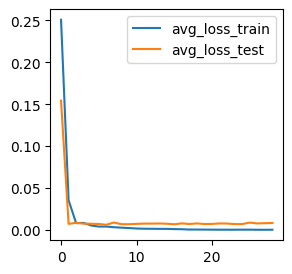

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  grad_mae  \
tvae        0.068319        0.073965   0.00234       4.434747  0.131697   

      grad_mape  grad_rmse  mean_pred_loss  pred_duration  pred_mae  \
tvae   1.324677   0.361238        0.000015       2.425093  0.035608   

      pred_mape  pred_rmse  pred_std  std_loss  total_duration  
tvae   0.066606   0.048377  0.066545  0.021388         6.85984

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../treatment/_cache_test/tvae/all inf False


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'tvae': 0.5567177837355095}


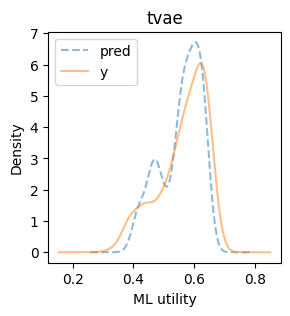

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

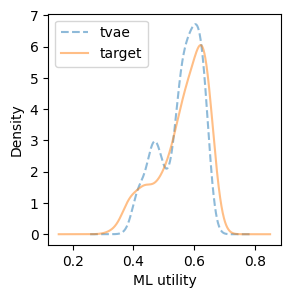

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

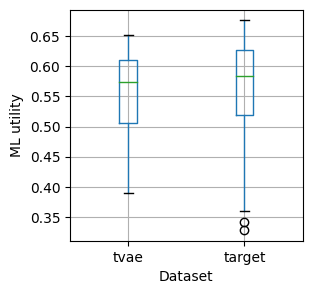

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

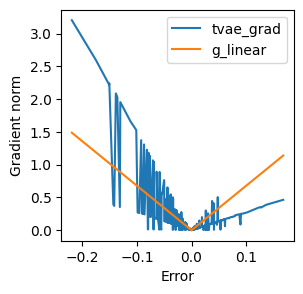

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""